In [5]:
import numpy as np
import pandas as pd
from transformers import BertModel
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#the virtual environment is new_bert

In [4]:
!pip install scikit-learn


  Using cached scikit_learn-1.5.2-cp39-cp39-win_amd64.whl.metadata (13 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp39-cp39-win_amd64.whl (11.0 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [3]:
df=pd.read_csv('../datasets/CREMA-D/MELD-master/data/MELD/train_sent_emo.csv', delimiter=',', nrows = None)


In [4]:
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [5]:
text_df=df['Utterance']
text_df=pd.DataFrame(text_df)
text_df.head()


,Utterance
0,also I was the point person on my company’s tr...
1,You must’ve had your hands full.
2,That I did. That I did.
3,So let’s talk a little bit about your duties.
4,My duties? All right.


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(text):
    # Tokenize, pad, and truncate
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

text_df['input_ids'] = text_df['Utterance'].apply(lambda x: preprocess(x)['input_ids'][0])
text_df['attention_mask'] = text_df['Utterance'].apply(lambda x: preprocess(x)['attention_mask'][0])


In [ ]:


class TextDataset(Dataset):
    def __init__(self,input_ids,attention_masks):
        self.input_ids=input_ids
        self.attention_masks=attention_masks
    def __len__(self):
        return len(self.input_ids)
    def __getitem__(self,idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
        }

dataset=TextDataset(text_df['input_ids'].to_list(),text_df['attention_mask'].to_list())
train_loader = DataLoader(dataset, shuffle=False)


In [12]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Check if CUDA is available

2.5.0+cpu
False


In [ ]:
#############################################

#training bert


########################################

In [ ]:

# Load model and force it to use the CPU
model = BertModel.from_pretrained('bert-base-uncased', num_labels=7).to('cpu')
model.eval()

from tqdm import tqdm
encodings = []

# Force DataLoader batches to remain on the CPU
with torch.no_grad():
    for batch in tqdm(train_loader):
        outputs = model(
            input_ids=batch['input_ids'],  # Default is CPU
            attention_mask=batch['attention_mask'],  # Default is CPU
        )
        encoding = outputs.last_hidden_state
        encodings.append(encoding)


  0%|          | 0/9989 [00:00<?, ?it/s]C:\Users\dell\AppData\Local\Temp\ipykernel_18816\707734850.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
C:\Users\dell\AppData\Local\Temp\ipykernel_18816\707734850.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
100%|██████████| 9989/9989 [29:04<00:00,  5.73it/s]


In [13]:
encodings[9987]


tensor([[[-0.3271, -0.0116, -0.0164,  ..., -0.1454,  0.4163,  0.1177],
         [ 0.7810, -0.1910,  0.3150,  ..., -0.3541,  0.9698, -0.2329],
         [-0.2891, -0.7291,  0.1984,  ...,  0.8826,  0.8325, -0.5647],
         ...,
         [ 0.2801,  0.3044,  0.5951,  ...,  0.1329,  0.4678, -0.0913],
         [-0.2380, -0.1202,  0.5666,  ...,  0.6372,  0.5232, -0.1867],
         [ 0.1859,  0.2200,  0.6492,  ...,  0.0793,  0.3894, -0.0810]]])

In [14]:
text_encodings=[t.flatten() for t in encodings]


In [15]:
bert_encodings_np = [encoding.cpu().numpy() for encoding in text_encodings]


In [16]:
type(bert_encodings_np[0])


numpy.ndarray

In [17]:
import pickle
with open('text_embeddings.pkl', 'wb') as f:
    pickle.dump(bert_encodings_np, f)


In [18]:
with open('text_embeddings.pkl', 'rb') as f:
    loaded_array_list = pickle.load(f)


In [20]:
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Prepare labels (map emotion labels to numbers)
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
df['label'] = df['Emotion'].map(label_mapping)

# Create dataset and dataloaders
dataset = TextDataset(
    text_df['input_ids'].to_list(),
    text_df['attention_mask'].to_list(),
    df['label'].to_list()
)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:

# Load pre-trained BERT with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7).to('cpu')

# Define optimizer and loss function
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
import os
import torch

def save_checkpoint(epoch, model, optimizer, loss, filepath="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch + 1}")


In [24]:
epochs = 3
checkpoint_path = "bert_emotion_checkpoint.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to('cpu'),
            attention_mask=batch['attention_mask'].to('cpu'),
            labels=batch['labels'].to('cpu'),
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Save checkpoint at the end of each epoch
    save_checkpoint(epoch, model, optimizer, total_loss / len(train_loader), checkpoint_path)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


C:\Users\dell\AppData\Local\Temp\ipykernel_18816\1479609361.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
C:\Users\dell\AppData\Local\Temp\ipykernel_18816\1479609361.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Checkpoint saved at epoch 1
Epoch 1/3, Loss: 1.137200417610022
Checkpoint saved at epoch 2
Epoch 2/3, Loss: 0.9028418294537943
Checkpoint saved at epoch 3
Epoch 3/3, Loss: 0.6272407133167925


In [ ]:
#####################################


#testing the model bert 


####################################

In [26]:
import pandas as pd
from transformers import BertTokenizer

# Load the test dataset
test_df = pd.read_csv('../datasets/CREMA-D/MELD-master/data/MELD/test_sent_emo.csv', delimiter=',')

# Preprocess the text data (like you did for training data)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

test_df['input_ids'] = test_df['Utterance'].apply(lambda x: preprocess(x)['input_ids'][0])
test_df['attention_mask'] = test_df['Utterance'].apply(lambda x: preprocess(x)['attention_mask'][0])


In [27]:
# Map emotions to numbers (same as training)
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
test_df['label'] = test_df['Emotion'].map(label_mapping)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create the test dataset
test_dataset = TestDataset(
    test_df['input_ids'].to_list(),
    test_df['attention_mask'].to_list(),
    test_df['label'].to_list()
)

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [32]:
!pip install joblib


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.0 requires threadpoolctl>=2.0.0, which is not installed.


In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Indicate that evaluation is starting
print("Evaluating on the testing dataset...")

# Put the model in evaluation mode
model.eval()

true_labels = []
predicted_labels = []

# Run inference on the test data
with torch.no_grad():
    for batch in test_loader:
        outputs = model(
            input_ids=batch['input_ids'].to('cpu'),
            attention_mask=batch['attention_mask'].to('cpu')
        )
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels.extend(batch['labels'].cpu().numpy())
        predicted_labels.extend(predictions)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print metrics
print(f"Evaluation Completed for Testing Dataset:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Evaluating on the testing dataset...


C:\Users\dell\AppData\Local\Temp\ipykernel_18816\1487393600.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
C:\Users\dell\AppData\Local\Temp\ipykernel_18816\1487393600.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Evaluation Completed for Testing Dataset:
Accuracy: 62.26%
F1-Score: 0.60
Precision: 0.60
Recall: 0.62


In [35]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm


In [ ]:
# Load training and testing data
train_df = pd.read_csv('../datasets/CREMA-D/MELD-master/data/MELD/train_sent_emo.csv', delimiter=',')
test_df = pd.read_csv('../datasets/CREMA-D/MELD-master/data/MELD/test_sent_emo.csv', delimiter=',')

# Map emotions to numerical labels
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
train_df['label'] = train_df['Emotion'].map(label_mapping)
test_df['label'] = test_df['Emotion'].map(label_mapping)

# Initialize Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Preprocess function
def preprocess(data):
    inputs = tokenizer(
        data['Utterance'].tolist(),  # Input sentences
        padding=True,
        truncation=True,
        max_length=128,  # Limit sequence length
        return_tensors="pt"
    )
    return inputs


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [37]:
train_inputs = preprocess(train_df)
test_inputs = preprocess(test_df)


In [38]:
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }


In [39]:
# Create datasets
train_dataset = EmotionDataset(train_inputs, train_df['label'].tolist())
test_dataset = EmotionDataset(test_inputs, test_df['label'].tolist())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [40]:
# Initialize the RoBERTa model with a classification head
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=7)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 625/625 [1:03:14<00:00,  6.07s/it]


Epoch 1 Loss: 1.2397820226192475


Epoch 2: 100%|██████████| 625/625 [9:44:23<00:00, 56.10s/it]      


Epoch 2 Loss: 1.0316494435310364


Epoch 3: 100%|██████████| 625/625 [56:02<00:00,  5.38s/it] 

Epoch 3 Loss: 0.8936432160377502


In [42]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device)
        )
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels.extend(batch['labels'].numpy())
        predicted_labels.extend(predictions)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Evaluating: 100%|██████████| 164/164 [03:13<00:00,  1.18s/it]

Accuracy: 64.02%
F1-Score: 0.63
Precision: 0.64
Recall: 0.64


In [7]:
model.save_pretrained("roberta_emotion_model")


In [ ]:
####################################

#trying to get better results 


#######################################

Dataset loaded successfully!
Shape of the dataset: (9989, 11)

--- First Few Rows ---
   Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my company’s tr...         Chandler   
1       2                   You must’ve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So let’s talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartT

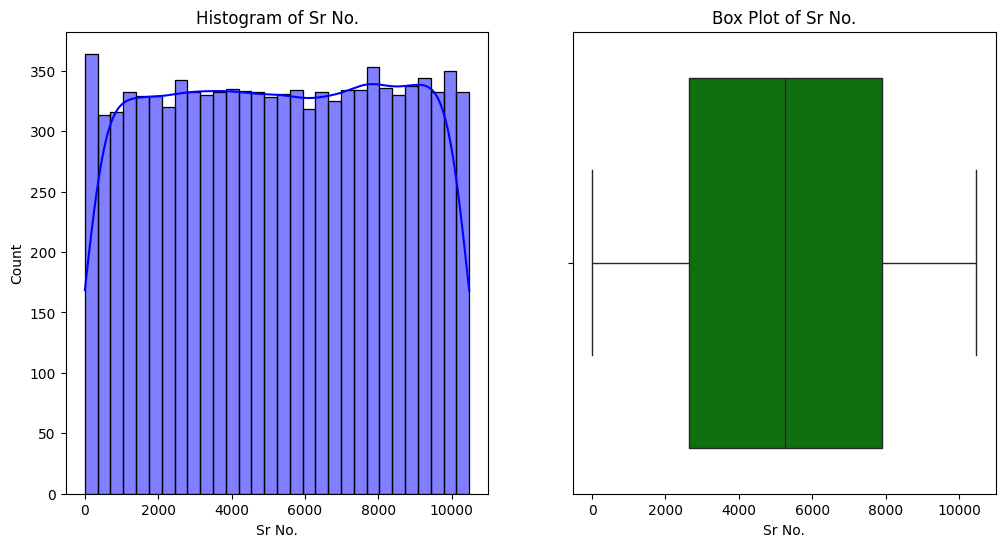

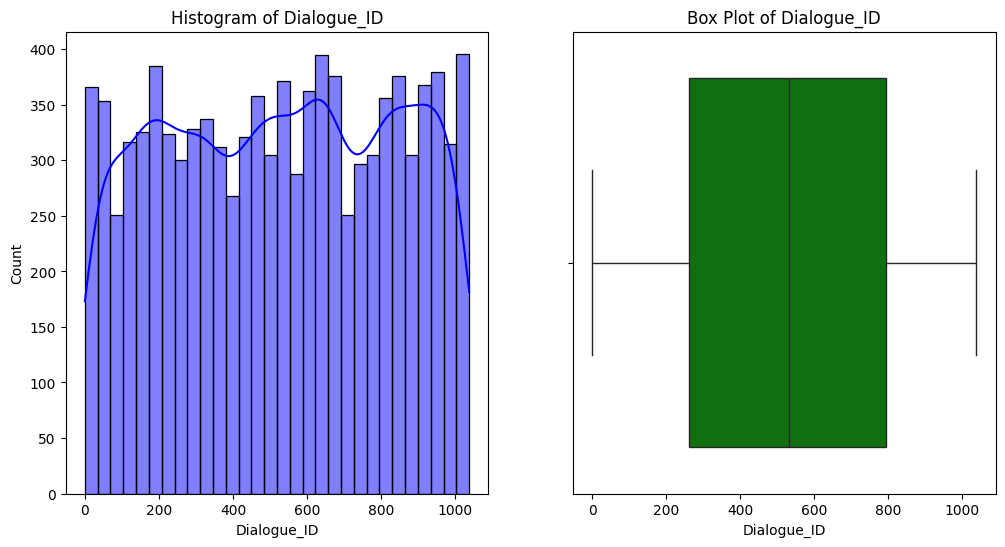

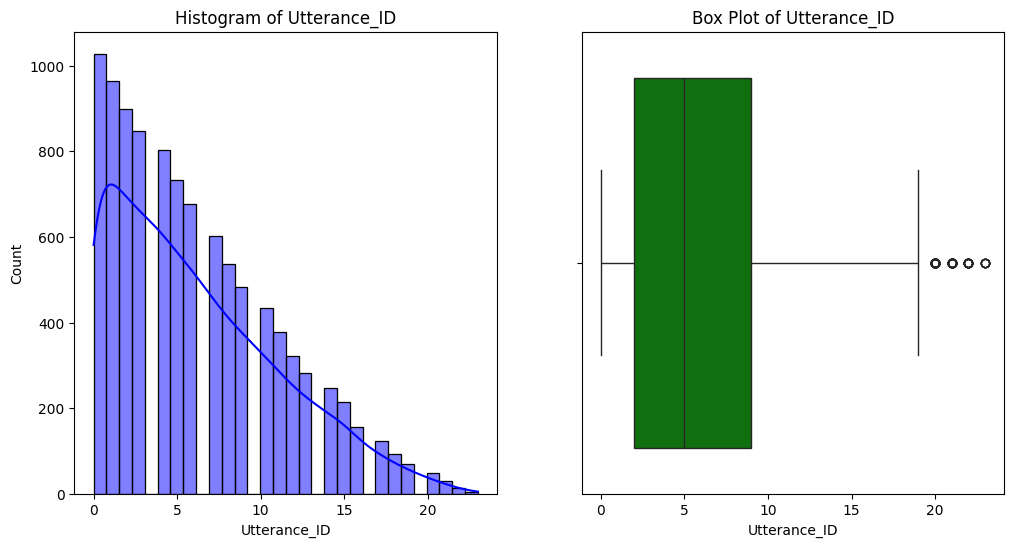

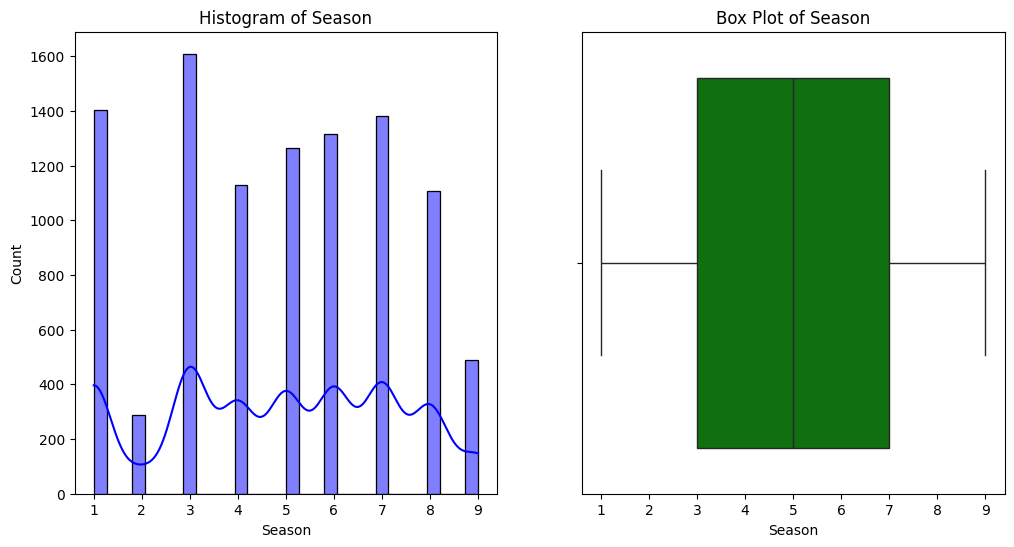

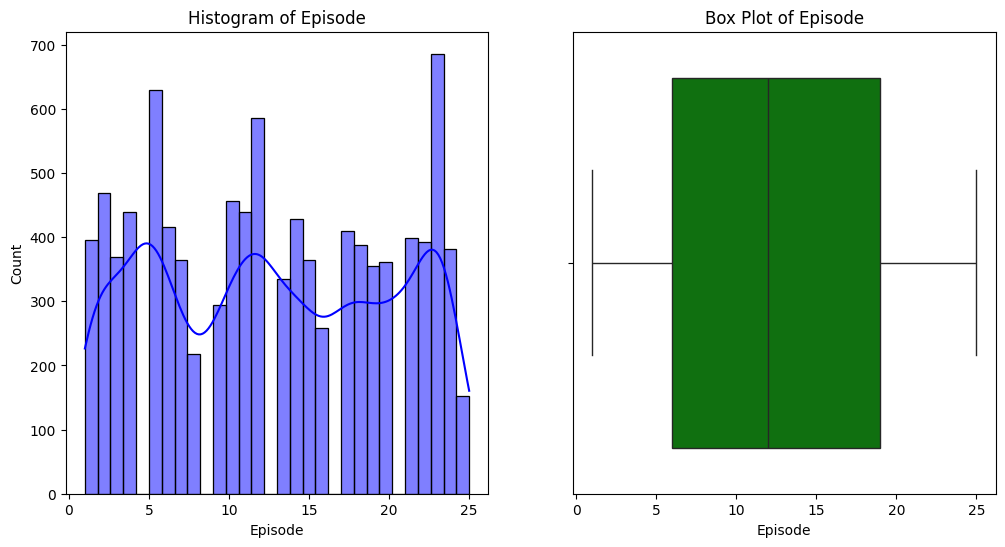


--- Visualizing Categorical Data ---


C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


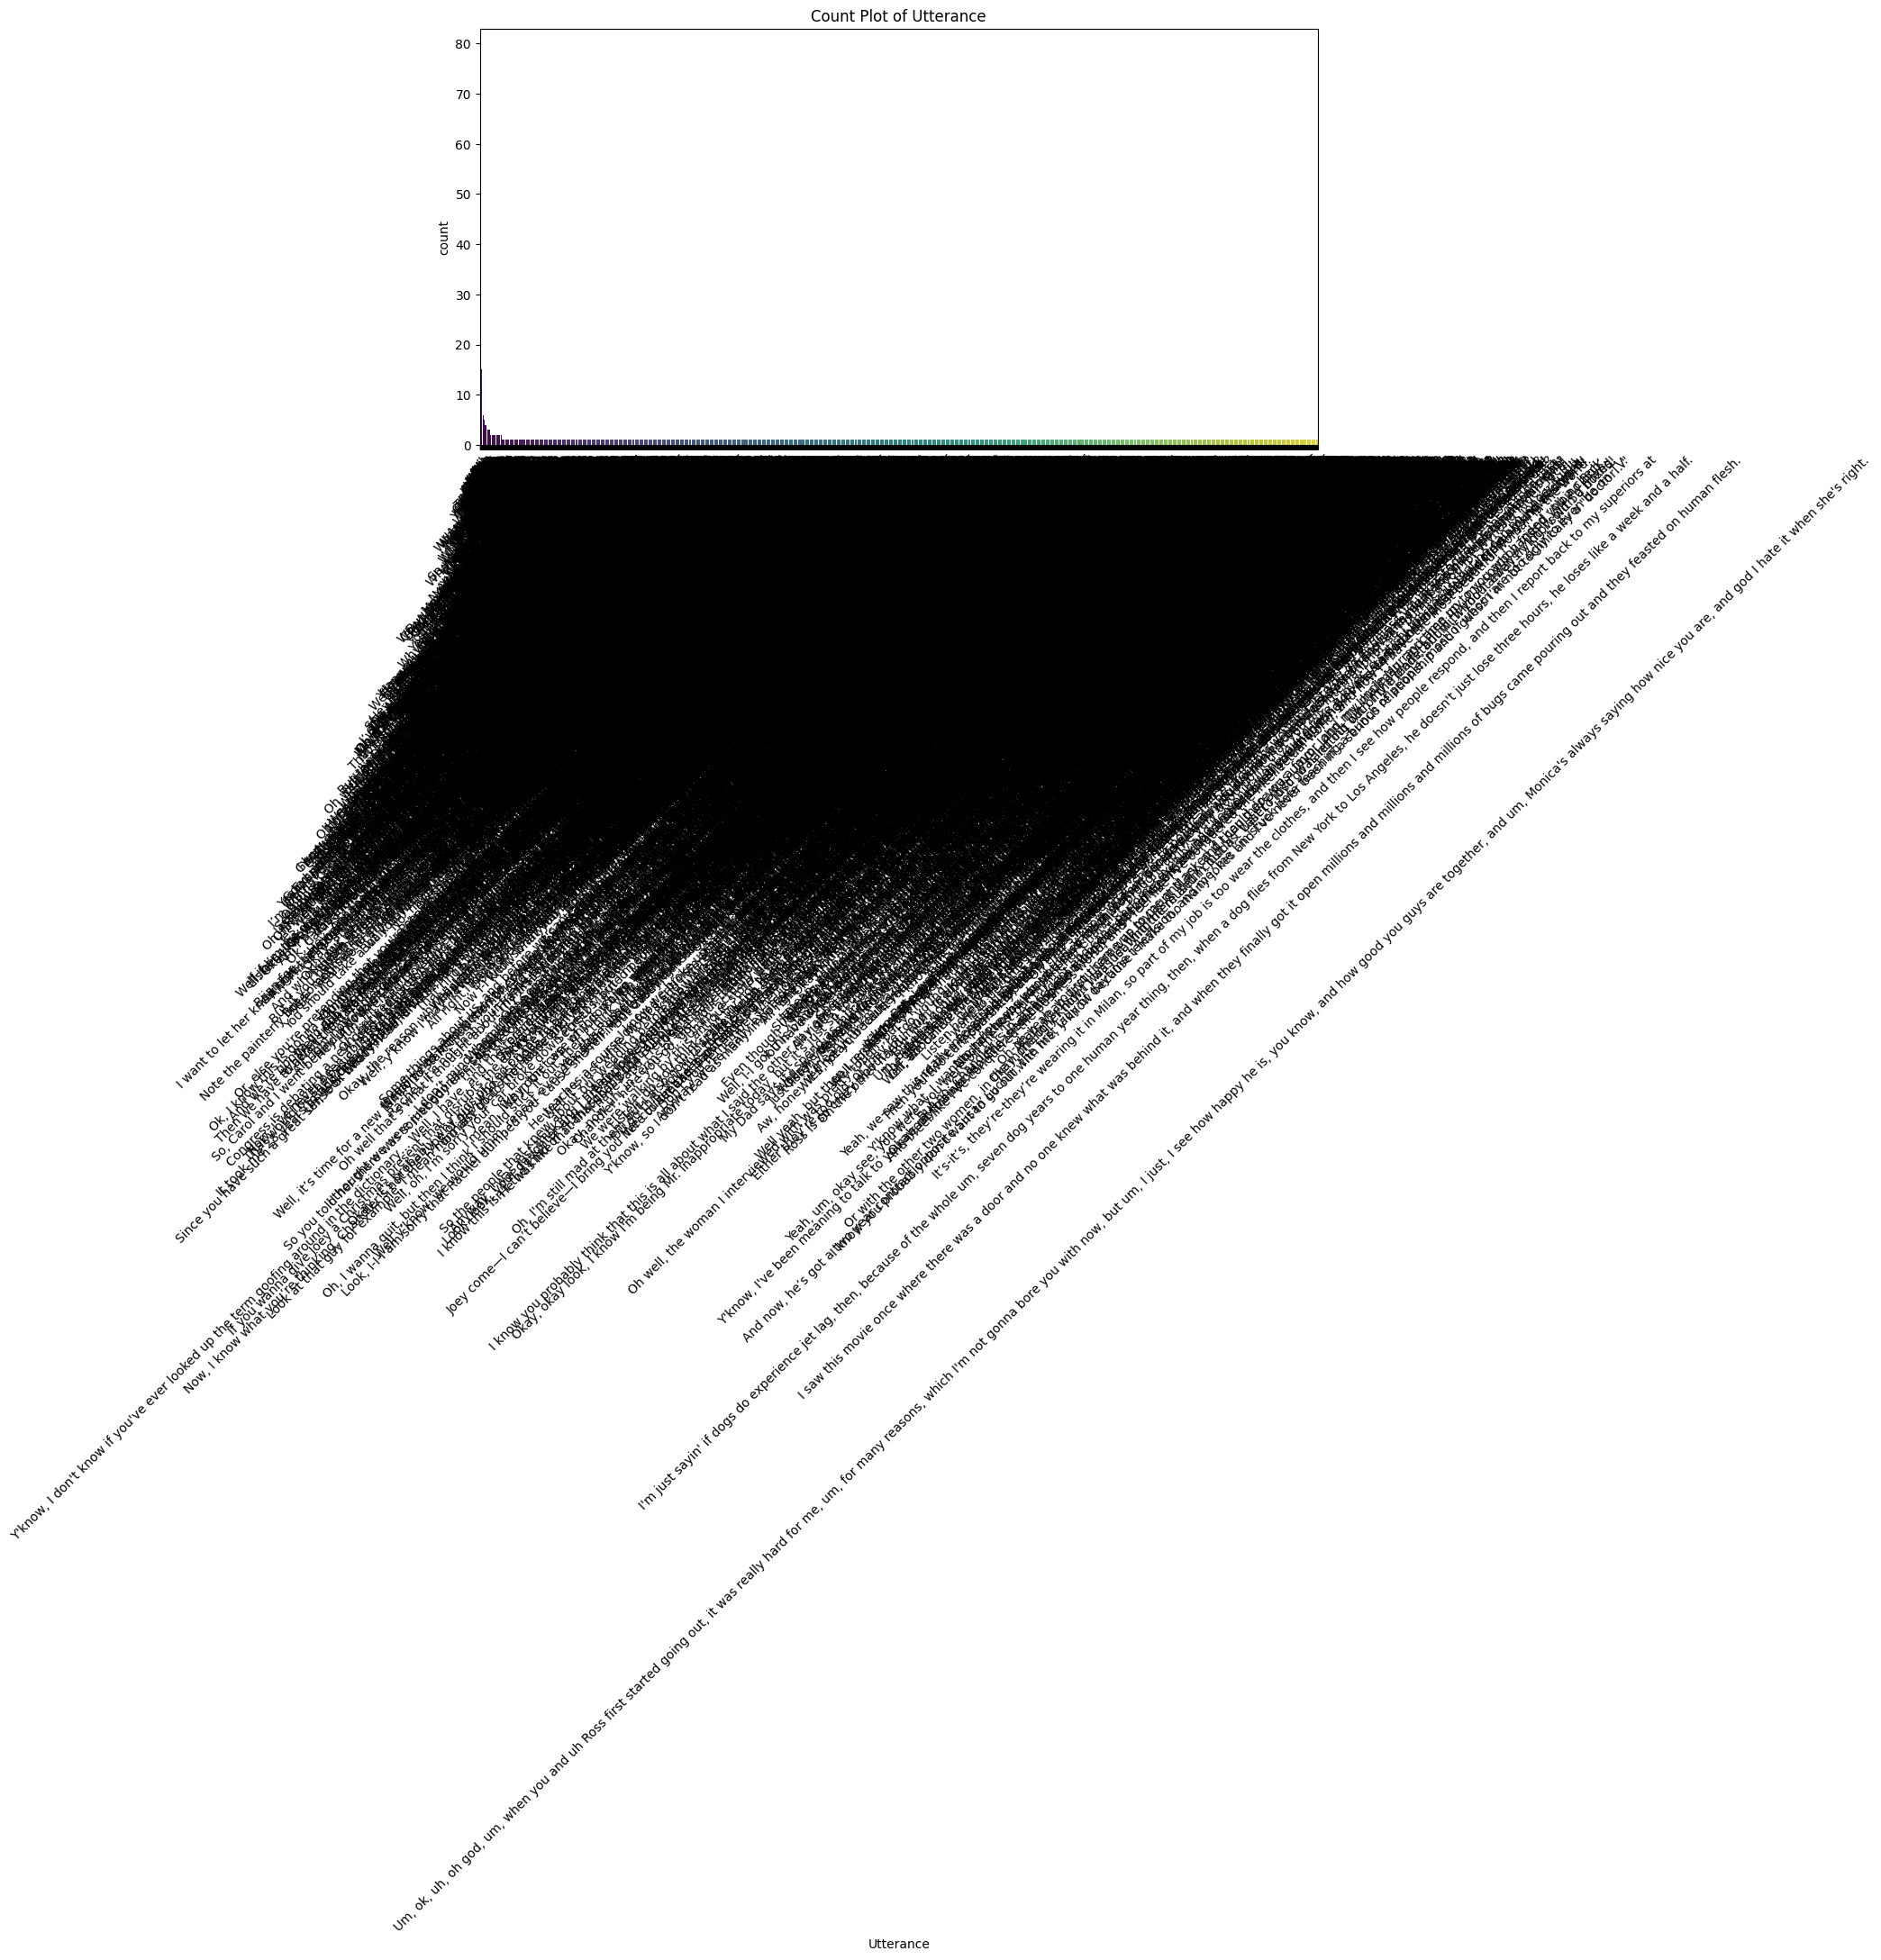

C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


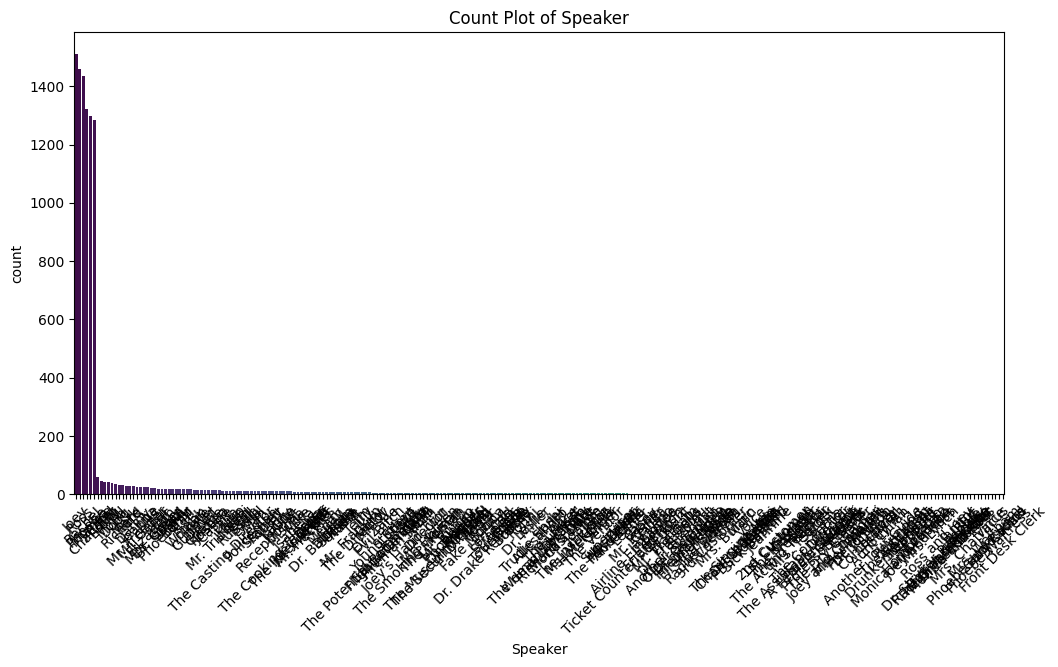

C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


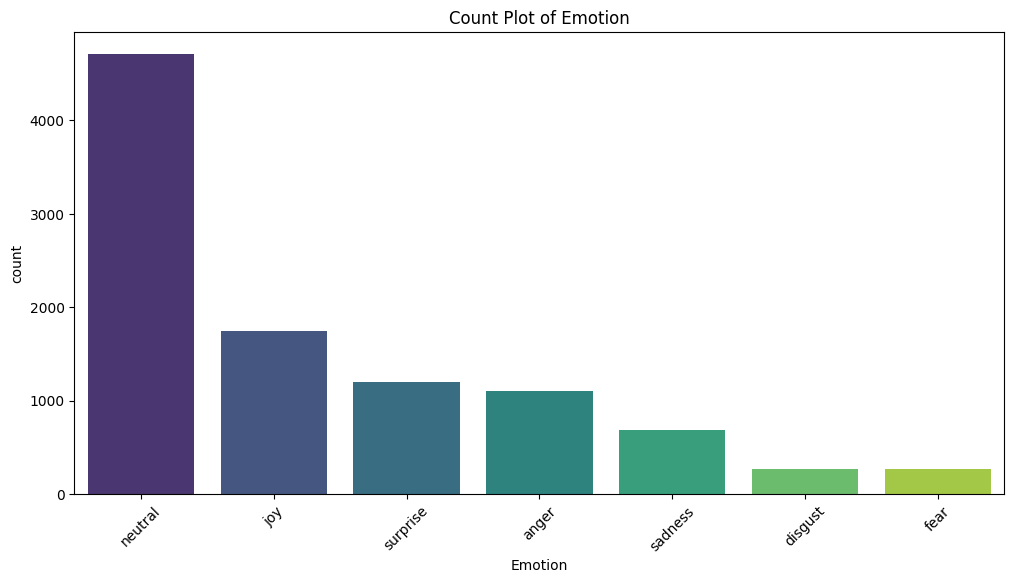

C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


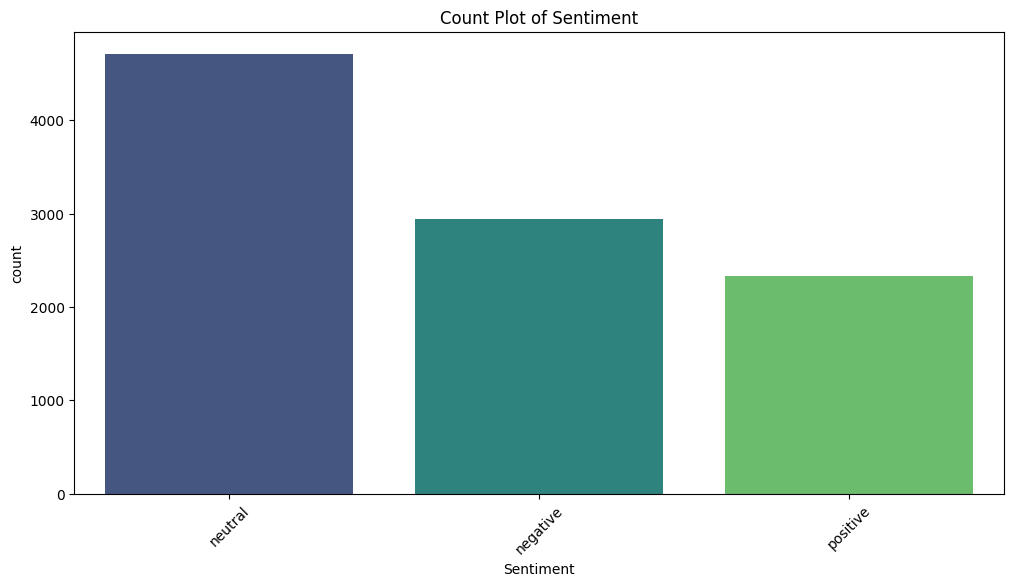

C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


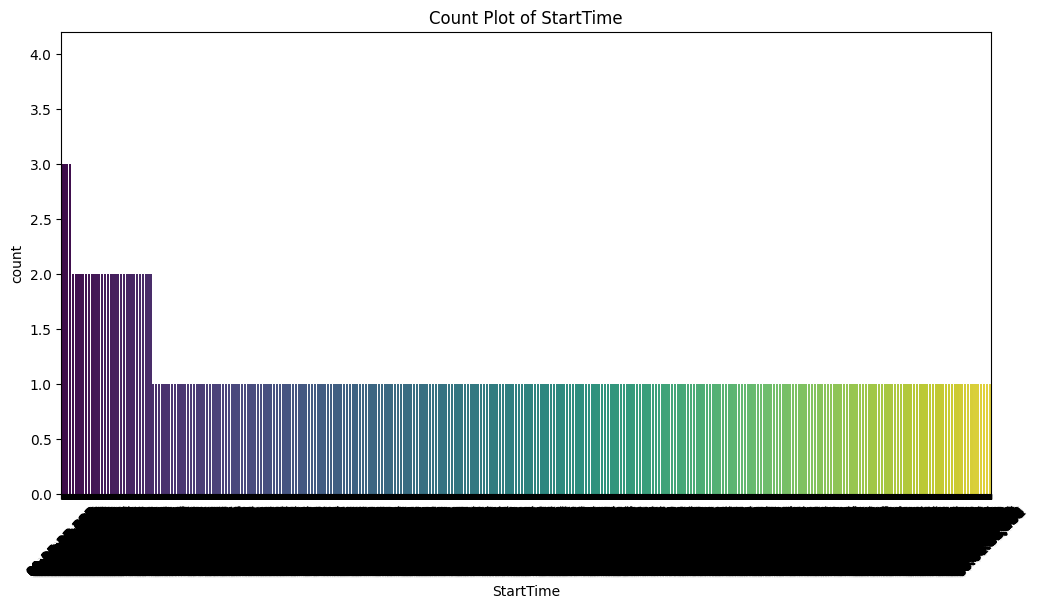

C:\Users\dell\AppData\Local\Temp\ipykernel_17300\1045516445.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')


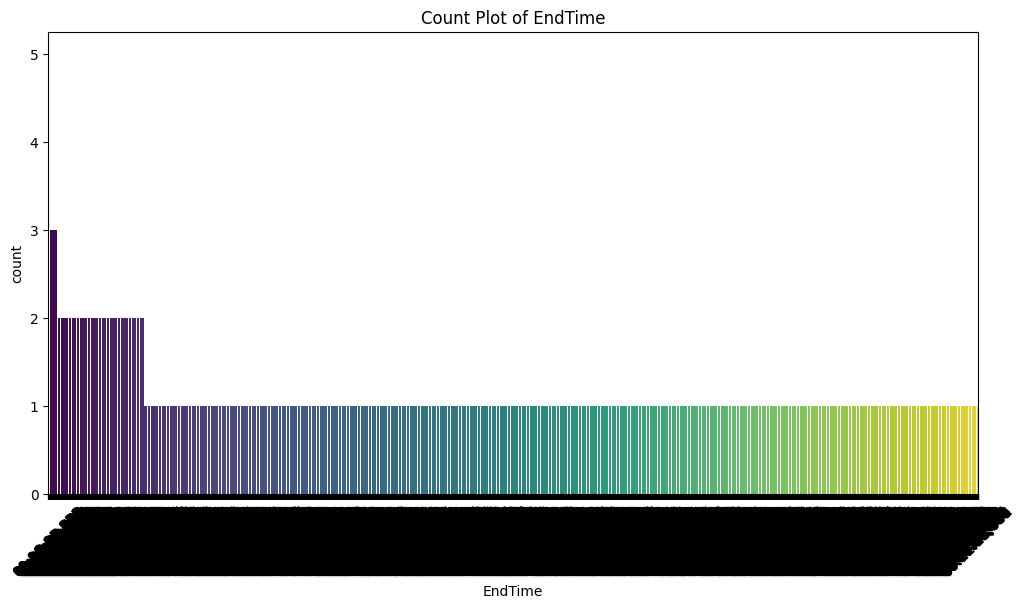

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Dataset
def load_dataset(file_path):
    """Load the dataset from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        print(f"Shape of the dataset: {df.shape}")
        print("\n--- First Few Rows ---")
        print(df.head())  # Display first few rows
        return df
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# 2. Basic EDA
def basic_eda(df):
    """Perform basic EDA: structure, data types, missing values, and summary stats."""
    print("\n--- Basic Info ---")
    print(df.info())
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
    print("\n--- Summary Statistics ---")
    print(df.describe(include='all'))
    print("\n--- First Few Rows ---")
    print(df.head())

# 3. Visualizations for Numerical Data
def visualize_numerical_data(df, numerical_columns):
    """Generate histograms and box plots for numerical columns."""
    if len(numerical_columns) == 0:
        print("No numerical columns found for visualization.")
        return

    for col in numerical_columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30, color='blue')
        plt.title(f"Histogram of {col}")

        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='green')
        plt.title(f"Box Plot of {col}")

        plt.show()

# 4. Visualizations for Categorical Data
def visualize_categorical_data(df, categorical_columns):
    """Generate count plots for categorical columns."""
    if len(categorical_columns) == 0:
        print("No categorical columns found for visualization.")
        return

    for col in categorical_columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')
        plt.title(f"Count Plot of {col}")
        plt.xticks(rotation=45)
        plt.show()

# Main Workflow
def perform_eda(file_path):
    """Complete EDA workflow."""
    # Load dataset
    df = load_dataset(file_path)
    if df is None:
        return

    # Perform EDA
    basic_eda(df)

    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    print(f"\nNumerical Columns: {numerical_columns}")
    print(f"Categorical Columns: {categorical_columns}")

    # Visualize data
    if numerical_columns:
        print("\n--- Visualizing Numerical Data ---")
        visualize_numerical_data(df, numerical_columns)

    if categorical_columns:
        print("\n--- Visualizing Categorical Data ---")
        visualize_categorical_data(df, categorical_columns)

# Run the workflow
file_path = '../datasets/CREMA-D/MELD-master/data/MELD/train_sent_emo.csv'
perform_eda(file_path)


In [2]:
# File paths
dataset_path = '../datasets/CREMA-D/MELD-master/data/MELD/train_sent_emo.csv'
outlier_summary_path = '../multimodel/outlier_summary.csv'
cleaned_dataset_path = '../multimodel/train_sent_emo_cleaned.csv'

# Load the original dataset
df = pd.read_csv(dataset_path)
print(f"Original dataset shape: {df.shape}")

# Load the outlier summary
outliers = pd.read_csv(outlier_summary_path)
print(f"Outlier summary shape: {outliers.shape}")

# Drop rows with indices listed in the outlier summary
outlier_indices = outliers.index
df_cleaned = df.drop(index=outlier_indices, errors='ignore')
print(f"Cleaned dataset shape: {df_cleaned.shape}")

# Save the cleaned dataset
df_cleaned.to_csv(cleaned_dataset_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_dataset_path}")


Original dataset shape: (9989, 11)
Outlier summary shape: (97, 11)
Cleaned dataset shape: (9892, 11)
Cleaned dataset saved to: ../multimodel/train_sent_emo_cleaned.csv


In [ ]:
################################

#audio part :


###############################

In [5]:
import os
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
model_path = "../multimodel/best_roberta_emotion_model"
train_data_path = r'../multimodel/train_sent_emo_cleaned.csv'
test_data_path = r'../datasets/CREMA-D/MELD-master/data/MELD/test_sent_emo.csv'

# Load saved model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(model_path)
model = model.to(device)

print("Model and tokenizer loaded successfully.")

# Load datasets
train_df = pd.read_csv(train_data_path, delimiter=',')
test_df = pd.read_csv(test_data_path, delimiter=',')

# Map emotions to numerical labels
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
train_df['label'] = train_df['Emotion'].map(label_mapping)
test_df['label'] = test_df['Emotion'].map(label_mapping)

# Preprocess function
def preprocess(data):
    inputs = tokenizer(
        data['Utterance'].tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    return inputs

train_inputs = preprocess(train_df)
test_inputs = preprocess(test_df)

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets and DataLoaders
train_dataset = EmotionDataset(train_inputs, train_df['label'].tolist())
test_dataset = EmotionDataset(test_inputs, test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels.extend(batch['labels'].cpu().numpy())
            predicted_labels.extend(predictions)

    # Metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    print(f"Validation Loss: {val_loss / len(loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1-Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# Evaluate the loaded model
print("Evaluating the loaded model...")
evaluate_model(model, test_loader)

# Optionally, resume fine-tuning
resume_fine_tuning = True
if resume_fine_tuning:
    print("Resuming fine-tuning...")
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    num_training_steps = len(train_loader) * 2  # 2 additional epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

    for epoch in range(2):  # 2 additional epochs
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")

    # Save the fine-tuned model
    model.save_pretrained("best-fine_tuned_roberta_emotion")
    print("Fine-tuned model saved.")

# Re-evaluate after fine-tuning
print("Evaluating the fine-tuned model...")
evaluate_model(model, test_loader)


Model and tokenizer loaded successfully.
Evaluating the loaded model...


Evaluating: 100%|██████████| 164/164 [02:51<00:00,  1.04s/it]
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Loss: 1.0936
Accuracy: 62.84%
F1-Score: 0.61
Precision: 0.60
Recall: 0.63
Resuming fine-tuning...


Epoch 1: 100%|██████████| 619/619 [57:06<00:00,  5.54s/it]


Epoch 1 Loss: 1.0220


Epoch 2: 100%|██████████| 619/619 [56:31<00:00,  5.48s/it] 


Epoch 2 Loss: 0.8555
Fine-tuned model saved.
Evaluating the fine-tuned model...


Evaluating: 100%|██████████| 164/164 [02:38<00:00,  1.04it/s]

Validation Loss: 1.0834
Accuracy: 64.64%
F1-Score: 0.63
Precision: 0.64
Recall: 0.65


In [12]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
train_df_balanced, train_labels_balanced = ros.fit_resample(train_df[['Utterance']], train_df['label'])
train_df['Utterance'] = train_df_balanced
train_df['label'] = train_labels_balanced


In [13]:
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(label_mapping))
model = model.to(device)


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and ar

In [15]:
from transformers import get_scheduler

optimizer = AdamW(
    [
        {"params": model.roberta.encoder.layer[:6].parameters(), "lr": 1e-5},
        {"params": model.roberta.encoder.layer[6:].parameters(), "lr": 2e-5},
        {"params": model.classifier.parameters(), "lr": 5e-5},
    ],
    weight_decay=0.01,
)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from tqdm import tqdm

# Training loop
def train_model(model, train_loader, optimizer, scheduler, epochs=2):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")
    print("Training complete.")


In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Prints the name of your GPU
else:
    print("CUDA is not available or not configured correctly.")


True
Quadro M2200


In [ ]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Suppress Windows symlink warnings
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Paths
train_data_path = r'../multimodel/train_sent_emo_cleaned.csv'
test_data_path = r'../datasets/CREMA-D/MELD-master/data/MELD/test_sent_emo.csv'

# Load model and tokenizer with ignore_mismatched_sizes
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/bert-base-go-emotion")
model = AutoModelForSequenceClassification.from_pretrained(
    "bhadresh-savani/bert-base-go-emotion",
    num_labels=7,  # Update based on your label mapping
    ignore_mismatched_sizes=True
)
model.to(device)

print("Model and tokenizer loaded successfully.")

# Load datasets
train_df = pd.read_csv(train_data_path, delimiter=',')
test_df = pd.read_csv(test_data_path, delimiter=',')

# Map emotions to numerical labels
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
train_df['label'] = train_df['Emotion'].map(label_mapping)
test_df['label'] = test_df['Emotion'].map(label_mapping)

# Preprocess function
def preprocess(data, tokenizer, max_len=256):
    inputs = tokenizer(
        data['Utterance'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return inputs

train_inputs = preprocess(train_df, tokenizer)
test_inputs = preprocess(test_df, tokenizer)

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets and DataLoaders
train_dataset = EmotionDataset(train_inputs, train_df['label'].tolist())
test_dataset = EmotionDataset(test_inputs, test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels.extend(batch['labels'].cpu().numpy())
            predicted_labels.extend(predictions)

    # Metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    print(f"Validation Loss: {val_loss / len(loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1-Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# Evaluate the loaded model
print("Evaluating the loaded model...")
evaluate_model(model, test_loader)

# Fine-tuning setup
resume_fine_tuning = True
if resume_fine_tuning:
    print("Resuming fine-tuning...")
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    num_training_steps = len(train_loader) * 2  # 2 additional epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

    for epoch in range(2):  # 2 additional epochs
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")

    # Save the fine-tuned model
    model.save_pretrained("best-fine_tuned_go_emotion_model")
    print("Fine-tuned model saved.")

# Re-evaluate after fine-tuning
print("Evaluating the fine-tuned model...")
evaluate_model(model, test_loader)


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/bert-base-go-emotion and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully.
Evaluating the loaded model...


Evaluating: 100%|██████████| 164/164 [00:50<00:00,  3.24it/s]
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Loss: 2.1090
Accuracy: 13.64%
F1-Score: 0.05
Precision: 0.07
Recall: 0.14
Resuming fine-tuning...


Epoch 1: 100%|██████████| 619/619 [15:04<00:00,  1.46s/it]


Epoch 1 Loss: 1.3158


Epoch 2: 100%|██████████| 619/619 [15:15<00:00,  1.48s/it]


Epoch 2 Loss: 1.1185
Fine-tuned model saved.
Evaluating the fine-tuned model...


Evaluating: 100%|██████████| 164/164 [01:02<00:00,  2.64it/s]

Validation Loss: 1.1359
Accuracy: 62.11%
F1-Score: 0.58
Precision: 0.57
Recall: 0.62



c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Suppress symlink warnings
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Paths
train_data_path = r'../multimodel/train_sent_emo_cleaned.csv'
test_data_path = r'../datasets/CREMA-D/MELD-master/data/MELD/test_sent_emo.csv'

# Define models and tokenizers
model_configs = [
    {"name": "roberta", "path": "roberta-base", "model": AutoModelForSequenceClassification, "tokenizer": AutoTokenizer},
    {"name": "bert", "path": "bert-base-uncased", "model": AutoModelForSequenceClassification, "tokenizer": AutoTokenizer},
    {"name": "custom", "path": "bhadresh-savani/bert-base-go-emotion", "model": AutoModelForSequenceClassification, "tokenizer": AutoTokenizer},
]

# Define grid search parameters
param_grid = {
    "learning_rate": [1e-5, 2e-5],
    "batch_size": [16, 32],
    "epochs": [2, 3]
}

# Load datasets
train_df = pd.read_csv(train_data_path, delimiter=',')
test_df = pd.read_csv(test_data_path, delimiter=',')

# Map emotions to numerical labels
label_mapping = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6}
train_df['label'] = train_df['Emotion'].map(label_mapping)
test_df['label'] = test_df['Emotion'].map(label_mapping)

# Preprocess function
def preprocess(data, tokenizer, max_len=256):
    inputs = tokenizer(
        data['Utterance'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return inputs

# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels.extend(batch['labels'].cpu().numpy())
            predicted_labels.extend(predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    return accuracy, f1, precision, recall, val_loss / len(loader)

# Fine-tuning function
def fine_tune_model(model, train_loader, test_loader, learning_rate, epochs):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    num_training_steps = len(train_loader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

    return model

# Grid search loop
results = []
grid = ParameterGrid(param_grid)

for config in model_configs:
    print(f"Evaluating model: {config['name']}")
    tokenizer = config["tokenizer"].from_pretrained(config["path"])
    model = config["model"].from_pretrained(config["path"], num_labels=7, ignore_mismatched_sizes=True).to(device)

    train_inputs = preprocess(train_df, tokenizer)
    test_inputs = preprocess(test_df, tokenizer)

    train_dataset = EmotionDataset(train_inputs, train_df['label'].tolist())
    test_dataset = EmotionDataset(test_inputs, test_df['label'].tolist())

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    for params in grid:
        print(f"Training with params: {params}")
        batch_size = params['batch_size']
        learning_rate = params['learning_rate']
        epochs = params['epochs']

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        fine_tuned_model = fine_tune_model(model, train_loader, test_loader, learning_rate, epochs)
        acc, f1, precision, recall, val_loss = evaluate_model(fine_tuned_model, test_loader)

        results.append({
            "model": config["name"],
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "accuracy": acc,
            "f1": f1,
            "precision": precision,
            "recall": recall,
            "val_loss": val_loss
        })

# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results.csv", index=False)
print("Grid search completed. Results saved to 'grid_search_results.csv'.")
